In [6]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
df = pd.read_csv("../combined.csv", index_col=0)
df

,Country,Customer ID,Invoice,Price,Stream ID,Times Viewed,Year,Month,Day,date
0,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28,2017-11-28
1,United Kingdom,13085.0,489434,6.75,79323W,12,2017,11,28,2017-11-28
2,United Kingdom,13085.0,489434,2.10,22041,21,2017,11,28,2017-11-28
3,United Kingdom,13085.0,489434,1.25,21232,5,2017,11,28,2017-11-28
4,United Kingdom,13085.0,489434,1.65,22064,17,2017,11,28,2017-11-28
...,...,...,...,...,...,...,...,...,...,...
815006,United Kingdom,16098.0,562271,3.75,22725,2,2019,7,31,2019-07-31
815007,United Kingdom,16098.0,562271,3.75,22726,12,2019,7,31,2019-07-31
815008,United Kingdom,16098.0,562271,3.75,22727,6,2019,7,31,2019-07-31
815009,United Kingdom,14056.0,562269,2.95,22090,2,2019,7,31,2019-07-31


In [16]:
#aggregate per country and per day
agg_df = df.groupby(by=["Country", "date"]).agg({"Price": "sum"}).reset_index()
agg_df

,Country,date,Price
0,Australia,2017-11-28,40.40
1,Australia,2017-12-04,10.10
2,Australia,2017-12-05,2.50
3,Australia,2017-12-15,6.65
4,Australia,2018-02-11,27.75
...,...,...,...
2529,Unspecified,2019-06-17,42.10
2530,Unspecified,2019-07-05,167.97
2531,Unspecified,2019-07-11,51.91
2532,Unspecified,2019-07-25,407.17


In [44]:
agg_df["date"] = pd.to_datetime(agg_df["date"])
# add missing values
appended_dfs = []
for country in agg_df["Country"].unique():
    temp_df = agg_df.loc[agg_df["Country"]==country, :]
    dr = pd.date_range(temp_df["date"].min(), 
                       temp_df["date"].max())
    temp_df = temp_df.set_index("date")
    s = temp_df["Price"]
    s = s.reindex(dr, fill_value=0)
    #temp_df = temp_df.reset_index()
    temp_df = pd.DataFrame(s.reset_index())
    temp_df["Country"] = country
    appended_dfs.append(temp_df)

In [51]:
df = pd.concat(appended_dfs)
df.columns = ["date", "Price", "Country"]

In [52]:
df

,date,Price,Country
0,2017-11-28,40.40,Australia
1,2017-11-29,0.00,Australia
2,2017-11-30,0.00,Australia
3,2017-12-01,0.00,Australia
4,2017-12-02,0.00,Australia
...,...,...,...
552,2019-07-22,0.00,Unspecified
553,2019-07-23,0.00,Unspecified
554,2019-07-24,0.00,Unspecified
555,2019-07-25,407.17,Unspecified


In [53]:
for country in df["Country"].unique():
    df.loc[df["Country"]==country, "Price_7d"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=7).sum()
    df.loc[df["Country"]==country, "Price_14d"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=14).sum()
    df.loc[df["Country"]==country, "Price_21d"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=21).sum()
    df.loc[df["Country"]==country, "Price_28d"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=28).sum()
    df.loc[df["Country"]==country, "Price_7d_der"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=2).apply(np.diff).rolling(window=7).mean()
    df.loc[df["Country"]==country, "Price_14d_der"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=2).apply(np.diff).rolling(window=14).mean()
    df.loc[df["Country"]==country, "Price_21d_der"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=2).apply(np.diff).rolling(window=21).mean()
    df.loc[df["Country"]==country, "Price_28d_der"] = df.loc[df["Country"]==country, "Price"].shift(1).rolling(window=2).apply(np.diff).rolling(window=28).mean()
df.dropna()

,date,Price,Country,Price_7d,Price_14d,Price_21d,Price_28d,Price_7d_der,Price_14d_der,Price_21d_der,Price_28d_der
29,2017-12-27,0.00,Australia,0.0,6.650000e+00,6.65,19.25,0.0,0.000,-0.119048,-1.442857
30,2017-12-28,0.00,Australia,0.0,6.650000e+00,6.65,19.25,0.0,0.000,0.000000,0.000000
31,2017-12-29,0.00,Australia,0.0,6.650000e+00,6.65,19.25,0.0,0.000,0.000000,0.000000
32,2017-12-30,0.00,Australia,0.0,-1.776357e-15,6.65,19.25,0.0,-0.475,0.000000,0.000000
33,2017-12-31,0.00,Australia,0.0,-1.776357e-15,6.65,19.25,0.0,0.000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
551,2019-07-21,0.00,Unspecified,0.0,5.191000e+01,219.88,219.88,0.0,0.000,0.000000,0.000000
552,2019-07-22,0.00,Unspecified,0.0,5.191000e+01,219.88,219.88,0.0,0.000,0.000000,0.000000
553,2019-07-23,0.00,Unspecified,0.0,5.191000e+01,219.88,219.88,0.0,0.000,0.000000,0.000000
554,2019-07-24,0.00,Unspecified,0.0,5.191000e+01,219.88,219.88,0.0,0.000,0.000000,0.000000


In [55]:
df["Month"] = df["date"].dt.month
df["Day"] = df["date"].dt.day

In [60]:
#target var
for country in df["Country"].unique():
    df.loc[df["Country"]==country, "target"] = df.loc[df["Country"]==country, "Price"].shift(-30).rolling(30).sum()

In [64]:
df.loc[df["Country"]=="Australia"].dropna().head(60)

,date,Price,Country,Price_7d,Price_14d,Price_21d,Price_28d,Price_7d_der,Price_14d_der,Price_21d_der,Price_28d_der,Month,Day,target
29,2017-12-27,0.00,Australia,0.00,6.650000e+00,6.650000e+00,1.925000e+01,0.000000,0.000000,-0.119048,-1.442857,12,27,0.00
30,2017-12-28,0.00,Australia,0.00,6.650000e+00,6.650000e+00,1.925000e+01,0.000000,0.000000,0.000000,0.000000,12,28,0.00
31,2017-12-29,0.00,Australia,0.00,6.650000e+00,6.650000e+00,1.925000e+01,0.000000,0.000000,0.000000,0.000000,12,29,0.00
32,2017-12-30,0.00,Australia,0.00,-1.776357e-15,6.650000e+00,1.925000e+01,0.000000,-0.475000,0.000000,0.000000,12,30,0.00
33,2017-12-31,0.00,Australia,0.00,-1.776357e-15,6.650000e+00,1.925000e+01,0.000000,0.000000,0.000000,0.000000,12,31,0.00
34,2018-01-01,0.00,Australia,0.00,-1.776357e-15,6.650000e+00,1.925000e+01,0.000000,0.000000,0.000000,0.000000,1,1,0.00
35,2018-01-02,0.00,Australia,0.00,-1.776357e-15,6.650000e+00,9.150000e+00,0.000000,0.000000,0.000000,-0.360714,1,2,0.00
36,2018-01-03,0.00,Australia,0.00,-1.776357e-15,6.650000e+00,6.650000e+00,0.000000,0.000000,0.000000,-0.089286,1,3,0.00
37,2018-01-04,0.00,Australia,0.00,-1.776357e-15,6.650000e+00,6.650000e+00,0.000000,0.000000,0.000000,0.000000,1,4,0.00
38,2018-01-05,0.00,Australia,0.00,-1.776357e-15,6.650000e+00,6.650000e+00,0.000000,0.000000,0.000000,0.000000,1,5,0.00


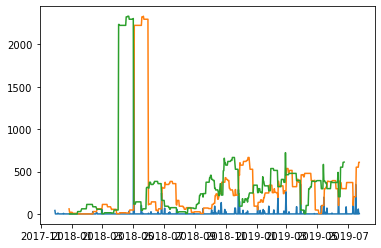

In [68]:
country = "Australia"
plot_df = df.loc[df["Country"]==country]
plt.plot(plot_df["date"], plot_df["Price"])
plt.plot(plot_df["date"], plot_df["Price_28d"])
plt.plot(plot_df["date"], plot_df["target"])

In [69]:
df = df.dropna()
df.to_csv("../train.csv", index=False)